In [1]:
# conda install -c menpo opencv
# https://stackoverflow.com/questions/23119413/how-do-i-install-python-opencv-through-conda
import cv2
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

print("hello world")

hello world


In [2]:
x = [1, 2]

In [3]:
y = x * 5

In [4]:
print(y)

[1, 2, 1, 2, 1, 2, 1, 2, 1, 2]


## Greyscale the image

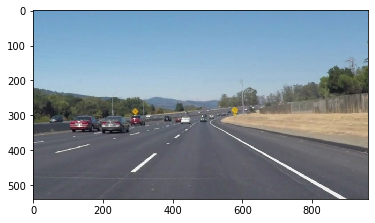

In [5]:
img = cv2.imread('test_images/solidWhiteCurve.jpg', cv2.IMREAD_COLOR)

# This is to compensate for the fact that 
# opencv image layers are stored in reverse order - BGR
# @alsosee https://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_color)



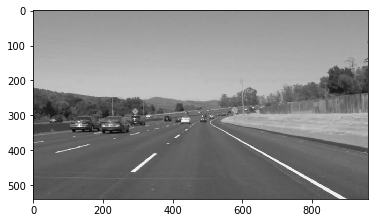

In [6]:
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cmap, vmin, vmax allow to print image as human expects it
plt.imshow(img_grey, cmap=cm.gray, vmin=0, vmax=255)

## Apply gradient filter to identify edges

Gradient filter can be applied to the grey scale image to identify
points on the where color intensity changes the most. 

On this example image these we can expect bright road lines to be picked 
up by the filter. 

Application of the GaussianBlur prior to Edge detection
reduces number of edgets that will be identified in the next step.

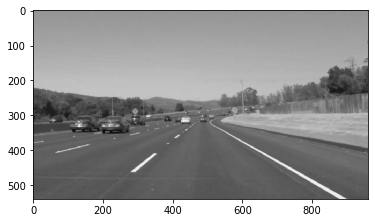

In [7]:
# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
img_blur = cv2.GaussianBlur(img_grey,(kernel_size, kernel_size), 0)

plt.imshow(img_blur, cmap=cm.gray, vmin=0, vmax=255)

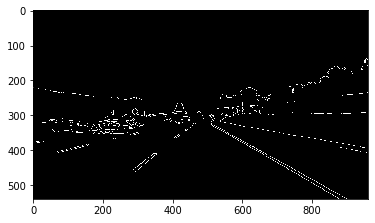

In [8]:
low_threshold = 60
high_threshold = 180
img_gradient = cv2.Canny(img_blur, low_threshold, high_threshold)

# Display the image
plt.imshow(img_gradient, cmap='Greys_r')

## Reduce image scope

To detect lanes on the road it will help to reduce the view
of the camera to the road ahead of the car which can be asumed 
to be a triangle formed between:

 - left bottom corner of the image
 - right bottom corner
 - point in the middle by x and 2/3 from the bottom by y

In [9]:
print(len(img_gradient.shape))

2


In [10]:
print(img_gradient.shape)

(540, 960)


2


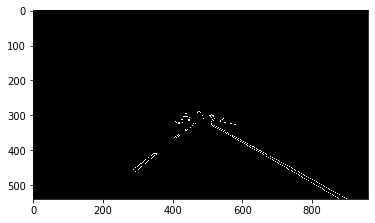

In [16]:
def lane_view_pixel(y, x, h, w):
    ### Evaluates whether pixel is in the area of the image where lines are expected ###
    
    x_mid = int(w / 2)
    y_cut = int(1 / 2 * h)
  

    if x <= x_mid:              
        # y_cut = h + m * x_mid
        # m = (y_cut - h) / x_mid

        m = (y_cut - h) / x_mid
        y_0 = h + m * x
        return y > y_0
                   
    if x > x_mid:
        # y_cut = m * x_mid
        # m = y_cut / x_mid
      
        m = y_cut / x_mid
        y_0 = m * x
        return y > y_0
         

def limit_view(image):
    img = image.copy()
    height, width = img.shape
    black = 0
    
    for x in range(0, width):
        for y in range(0, height):        
            if not lane_view_pixel(y, x, height, width):
                img[y, x] = black
    
    return img


print(len(img_gradient.shape))
img_limited_view = limit_view(img_gradient)

        
plt.imshow(img_limited_view, cmap='Greys_r')


In [12]:
for x in range(5, 10):
    print(x)

5
6
7
8
9


9


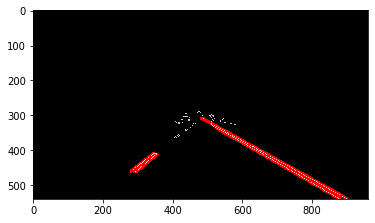

In [14]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi / 180
threshold = 2
min_line_length = 50
max_line_gap = 10

line_image = np.copy(img_limited_view) * 0 #creating a blank to draw lines on

# Run Hough on edge detected image
# OpenCV contains explanation of theory and parameters for HoughLinesP
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
lines = cv2.HoughLinesP(
    img_limited_view, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

print(len(lines))
# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)

plt.imshow(line_image)        
        
# Create a "color" binary image to combine with line image
color_edges = np.dstack((img_limited_view, img_limited_view, img_limited_view)) 

plt.imshow(color_edges)
line_image = cv2.merge((line_image, np.copy(line_image) * 0, np.copy(line_image) * 0))
# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)